In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import matplotlib.dates as mdates

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

path = '/content/drive/MyDrive/Filtered_Dataset/'

full_df = pd.read_parquet(path + 'filtered_data_2023.parquet')
print(full_df.shape)

(34921417, 24)


In [ ]:
full_df.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
fare_amount                     float64
total_amount                    float64
pickup_latitude                 float64
pickup_longitude                float64
dropoff_latitude                float64
dropoff_longitude               float64
trip_times                      float64
pickup_times                    float64
Speed                           float64
PU_month                          uint8
PU_day_of_month                   uint8
PU_day_of_week                    uint8
PU_hour                           uint8
PU_time_of_day                   object
Date                             object
Number_of_Pickups                 int64
Month                             int32
Number_of_Trips                   int64
dtype: object

Feature selection

In [ ]:
feature_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount']

In [ ]:
taxi_data_manh = full_df[feature_cols]

In [ ]:
hourly_pickups = taxi_data_manh.groupby(pd.Grouper(freq='H', key='tpep_pickup_datetime')).agg({
    'trip_distance': 'mean',
    'total_amount': 'mean'
})

hourly_pickups['PU_count'] = taxi_data_manh.groupby(pd.Grouper(freq='H', key='tpep_pickup_datetime')).size().values
hourly_pickups = hourly_pickups.reindex()

In [ ]:
# Reset the datetime index
hourly_data_wo_index = hourly_pickups.reset_index()

# Re-arrange the column order to get a better overview
pu_count = hourly_data_wo_index.pop('PU_count')
hourly_data_wo_index.insert(1, 'PU_count', pu_count)
print(hourly_data_wo_index)

     tpep_pickup_datetime  PU_count  trip_distance  total_amount
0     2023-01-01 00:00:00      4711       3.253647     26.641333
1     2023-01-01 01:00:00      4928       3.127843     26.007904
2     2023-01-01 02:00:00      4303       3.170618     25.319305
3     2023-01-01 03:00:00      3244       3.331245     25.547824
4     2023-01-01 04:00:00      2082       3.734558     26.933132
...                   ...       ...            ...           ...
8731  2023-12-30 19:00:00      4549       3.641457     29.826527
8732  2023-12-30 20:00:00      3981       3.861811     31.318058
8733  2023-12-30 21:00:00      3729       3.920762     31.153347
8734  2023-12-30 22:00:00      3913       3.916780     30.228352
8735  2023-12-30 23:00:00      2792       3.072067     25.911182

[8736 rows x 4 columns]


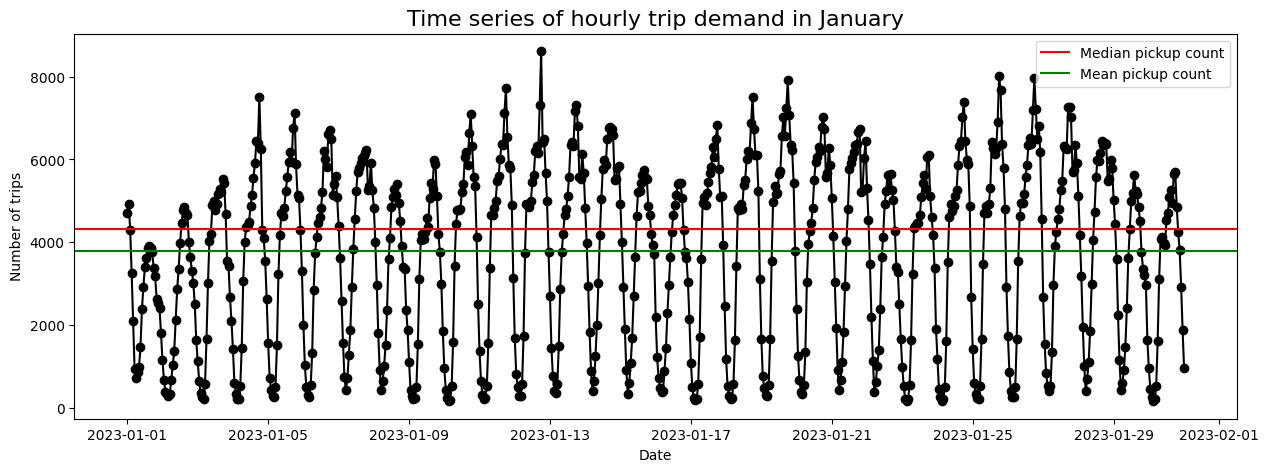

In [ ]:
# Use an exemplary time interval (January) to get an overview of the hourly demand time series

# Filter the data for January
filtered_data = hourly_data_wo_index[(hourly_data_wo_index['tpep_pickup_datetime'] >= '2023-01-01') & (hourly_data_wo_index['tpep_pickup_datetime'] <= '2023-01-31')]

# Create the time series plot

plt.figure(figsize=(15,5), dpi=100)
x = filtered_data['tpep_pickup_datetime']
y = filtered_data['PU_count']
plt.plot_date(x, y, color='black', linestyle='solid')
plt.xlabel("Date")
plt.axhline(y=np.median(y), color='red', label='Median pickup count')
plt.axhline(y=np.mean(y), color='green', label='Mean pickup count')
plt.ylabel("Number of trips")
plt.legend(fontsize=10)
plt.title("Time series of hourly trip demand in January", fontsize=16)
plt.show()

Feature engineering

In [ ]:
# Create new columns, representing the month, day of the month, day of the week, and hour of the pickup time extracted from the 'tpep_pickup_datetime' column

hourly_data_wo_index.insert(loc=2, column='PU_month', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.month)
hourly_data_wo_index.insert(loc=3, column='PU_day_of_month', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.day)
hourly_data_wo_index.insert(loc=4, column='PU_day_of_week', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.weekday)
hourly_data_wo_index.insert(loc=5, column='PU_hour', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.hour)

In [ ]:
manhattan_df = hourly_data_wo_index.copy()

# Add lagged features of the 'PU_count' column to the DataFrame with different time intervals (1 hour, 2 hours, 1 day, and 2 days)

manhattan_df.insert(8, 'lag_1h', manhattan_df['PU_count'].shift(1))
manhattan_df.insert(9, 'lag_2h', manhattan_df['PU_count'].shift(2))
manhattan_df.insert(10, 'lag_1d', manhattan_df['PU_count'].shift(24))
manhattan_df.insert(11, 'lag_2d', manhattan_df['PU_count'].shift(48))

# Filling the missing values in the lagged columns with 0 (to prevent NaNs at the beginning of the lagged columns)
manhattan_df['lag_1h'] = manhattan_df['lag_1h'].fillna(0)
manhattan_df['lag_2h'] = manhattan_df['lag_2h'].fillna(0)
manhattan_df['lag_1d'] = manhattan_df['lag_1d'].fillna(0)
manhattan_df['lag_2d'] = manhattan_df['lag_2d'].fillna(0)

In [ ]:
# Calculate the exponentially weighted moving averages (EWMA) of the 'PU_count' column  with different window sizes:
# 3 hours, 6 hours, 12 hours, and 24 hours
manhattan_df['ewma_3h'] = manhattan_df['PU_count'].ewm(span=3).mean()
manhattan_df['ewma_6h'] = manhattan_df['PU_count'].ewm(span=6).mean()
manhattan_df['ewma_12h'] = manhattan_df['PU_count'].ewm(span=12).mean()
manhattan_df['ewma_24h'] = manhattan_df['PU_count'].ewm(span=24).mean()
manhattan_df.head()

,tpep_pickup_datetime,PU_count,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,trip_distance,total_amount,lag_1h,lag_2h,lag_1d,lag_2d,ewma_3h,ewma_6h,ewma_12h,ewma_24h
0,2023-01-01 00:00:00,4711,1,1,6,0,3.253647,26.641333,0.0,0.0,0.0,0.0,4711.000000,4711.000000,4711.000000,4711.000000
1,2023-01-01 01:00:00,4928,1,1,6,1,3.127843,26.007904,4711.0,0.0,0.0,0.0,4855.666667,4837.583333,4828.541667,4824.020833
2,2023-01-01 02:00:00,4303,1,1,6,2,3.170618,25.319305,4928.0,4711.0,0.0,0.0,4539.857143,4597.266055,4623.422633,4635.681897
3,2023-01-01 03:00:00,3244,1,1,6,3,3.331245,25.547824,4303.0,4928.0,0.0,0.0,3848.733333,4074.551802,4187.992816,4243.115648
4,2023-01-01 04:00:00,2082,1,1,6,4,3.734558,26.933132,3244.0,4303.0,0.0,0.0,2936.870968,3375.221751,3615.802095,3735.987805


In [ ]:
manhattan_df.describe()

,tpep_pickup_datetime,PU_count,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,trip_distance,total_amount,lag_1h,lag_2h,lag_1d,lag_2d,ewma_3h,ewma_6h,ewma_12h,ewma_24h
count,8736,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8700.000000,8700.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000
mean,2023-07-01 23:30:00,3997.414950,6.510989,15.678571,3.000000,11.500000,3.829475,29.239902,3997.095353,3996.647436,3988.825321,3979.753091,3997.544736,3997.497585,3997.222174,3996.757530
min,2023-01-01 00:00:00,0.000000,1.000000,1.000000,0.000000,0.000000,0.400000,12.950000,0.000000,0.000000,0.000000,0.000000,0.001178,0.039956,0.274669,8.117375
25%,2023-04-01 23:45:00,1666.750000,4.000000,8.000000,1.000000,5.750000,3.122834,26.600664,1665.500000,1664.000000,1653.750000,1643.250000,2049.359899,2396.807829,2949.601855,3389.654081
50%,2023-07-01 23:30:00,4592.500000,7.000000,16.000000,3.000000,11.500000,3.459780,28.313853,4592.500000,4592.500000,4590.000000,4582.000000,4416.906287,4160.521622,3981.073740,3975.139852
75%,2023-09-30 23:15:00,5785.250000,9.250000,23.000000,5.000000,17.250000,4.107301,30.563304,5785.250000,5785.250000,5785.250000,5785.250000,5723.351939,5467.737398,5018.591981,4657.363904
max,2023-12-30 23:00:00,10114.000000,12.000000,31.000000,6.000000,23.000000,18.600000,92.690000,10114.000000,10114.000000,10114.000000,10114.000000,8948.469990,8277.532607,7501.003074,6594.548453
std,NaN,2322.209715,3.440806,8.772240,2.000114,6.922583,1.105688,4.338407,2322.567729,2322.961235,2329.589068,2336.603857,2150.945096,1833.250911,1351.998461,953.129305


In [ ]:
pu_count_range = manhattan_df['PU_count'].max() - manhattan_df['PU_count'].min()
print(f"Range of PU_count: {pu_count_range}")

# Calculate percentiles
percentiles = manhattan_df['PU_count'].quantile([0.25, 0.5, 0.75])
print(f"25th Percentile (Q1): {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile (Q3): {percentiles[0.75]}")

Range of PU_count: 10114
25th Percentile (Q1): 1666.75
50th Percentile (Median): 4592.5
75th Percentile (Q3): 5785.25


In [ ]:
# Export the final dataframe

manhattan_df.to_csv('/content/drive/MyDrive/Filtered_Dataset/global_temporal_features_withoutPUIDS.csv', index=False)

Correlation analysis of predictor variables

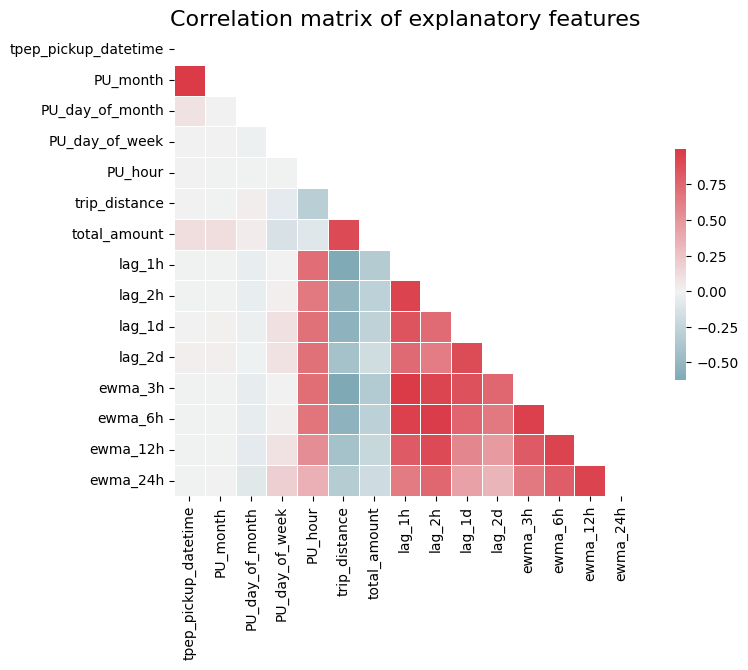

In [ ]:
# Visualization of the correlation matrix using a heatmap

# Compute the correlation matrix
corr_matrix = manhattan_df.corr()

# Exclude dependent variable 'PU_count' from the correlation matrix
corr_matrix_excluding_target = corr_matrix.drop('PU_count', axis=0).drop('PU_count', axis=1)


mask = np.triu(np.ones_like(corr_matrix_excluding_target, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix_excluding_target, mask=mask, cmap=cmap, annot=False, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix of explanatory features', fontsize=16)
# .savefig('multicoll_temporal.png')
plt.show()

In [ ]:
# Get all feature pairs with correlation greater than 0.7

high_corr_pairs = [(corr_matrix_excluding_target.columns[i], corr_matrix_excluding_target.columns[j]) for i in range(len(corr_matrix_excluding_target.columns))
                  for j in range(i+1, len(corr_matrix_excluding_target.columns)) if abs(corr_matrix_excluding_target.iloc[i,j]) > 0.7]

# Print the high correlated feature pairs
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]} have an autocorrelation > 0.7")

tpep_pickup_datetime and PU_month have an autocorrelation > 0.7
PU_hour and lag_1h have an autocorrelation > 0.7
PU_hour and ewma_3h have an autocorrelation > 0.7
trip_distance and total_amount have an autocorrelation > 0.7
lag_1h and lag_2h have an autocorrelation > 0.7
lag_1h and lag_1d have an autocorrelation > 0.7
lag_1h and lag_2d have an autocorrelation > 0.7
lag_1h and ewma_3h have an autocorrelation > 0.7
lag_1h and ewma_6h have an autocorrelation > 0.7
lag_1h and ewma_12h have an autocorrelation > 0.7
lag_2h and lag_1d have an autocorrelation > 0.7
lag_2h and ewma_3h have an autocorrelation > 0.7
lag_2h and ewma_6h have an autocorrelation > 0.7
lag_2h and ewma_12h have an autocorrelation > 0.7
lag_2h and ewma_24h have an autocorrelation > 0.7
lag_1d and lag_2d have an autocorrelation > 0.7
lag_1d and ewma_3h have an autocorrelation > 0.7
lag_1d and ewma_6h have an autocorrelation > 0.7
lag_2d and ewma_3h have an autocorrelation > 0.7
ewma_3h and ewma_6h have an autocorrelation

Temporal forecasting

In [ ]:
global_feat_data = pd.read_csv("/content/drive/MyDrive/Filtered_Dataset/global_temporal_features_withoutPUIDS.csv")

In [ ]:
global_feat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8736 entries, 0 to 8735
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tpep_pickup_datetime  8736 non-null   object 
 1   PU_count              8736 non-null   int64  
 2   PU_month              8736 non-null   int64  
 3   PU_day_of_month       8736 non-null   int64  
 4   PU_day_of_week        8736 non-null   int64  
 5   PU_hour               8736 non-null   int64  
 6   trip_distance         8687 non-null   float64
 7   total_amount          8687 non-null   float64
 8   lag_1h                8736 non-null   float64
 9   lag_2h                8736 non-null   float64
 10  lag_1d                8736 non-null   float64
 11  lag_2d                8736 non-null   float64
 12  ewma_3h               8736 non-null   float64
 13  ewma_6h               8736 non-null   float64
 14  ewma_12h              8736 non-null   float64
 15  ewma_24h             

In [ ]:
global_feat_data.head()

,tpep_pickup_datetime,PU_count,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,trip_distance,total_amount,lag_1h,lag_2h,lag_1d,lag_2d,ewma_3h,ewma_6h,ewma_12h,ewma_24h
0,2023-01-01 00:00:00,4711,1,1,6,0,3.253647,26.641333,0.0,0.0,0.0,0.0,4711.000000,4711.000000,4711.000000,4711.000000
1,2023-01-01 01:00:00,4928,1,1,6,1,3.127843,26.007904,4711.0,0.0,0.0,0.0,4855.666667,4837.583333,4828.541667,4824.020833
2,2023-01-01 02:00:00,4303,1,1,6,2,3.170618,25.319305,4928.0,4711.0,0.0,0.0,4539.857143,4597.266055,4623.422633,4635.681897
3,2023-01-01 03:00:00,3244,1,1,6,3,3.331245,25.547824,4303.0,4928.0,0.0,0.0,3848.733333,4074.551802,4187.992816,4243.115648
4,2023-01-01 04:00:00,2082,1,1,6,4,3.734558,26.933132,3244.0,4303.0,0.0,0.0,2936.870968,3375.221751,3615.802095,3735.987805


In [ ]:
global_feat_data.tail(len(global_feat_data)-1)[:-1]

,tpep_pickup_datetime,PU_count,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,trip_distance,total_amount,lag_1h,lag_2h,lag_1d,lag_2d,ewma_3h,ewma_6h,ewma_12h,ewma_24h
1,2023-01-01 01:00:00,4928,1,1,6,1,3.127843,26.007904,4711.0,0.0,0.0,0.0,4855.666667,4837.583333,4828.541667,4824.020833
2,2023-01-01 02:00:00,4303,1,1,6,2,3.170618,25.319305,4928.0,4711.0,0.0,0.0,4539.857143,4597.266055,4623.422633,4635.681897
3,2023-01-01 03:00:00,3244,1,1,6,3,3.331245,25.547824,4303.0,4928.0,0.0,0.0,3848.733333,4074.551802,4187.992816,4243.115648
4,2023-01-01 04:00:00,2082,1,1,6,4,3.734558,26.933132,3244.0,4303.0,0.0,0.0,2936.870968,3375.221751,3615.802095,3735.987805
5,2023-01-01 05:00:00,936,1,1,6,5,4.884231,31.538835,2082.0,3244.0,0.0,0.0,1920.555556,2571.567710,2964.469202,3166.949649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,2023-12-30 18:00:00,4809,12,30,5,18,3.447216,29.401320,4955.0,5260.0,5270.0,5102.0,4930.714834,4758.418619,4183.196049,3693.086072
8731,2023-12-30 19:00:00,4549,12,30,5,19,3.641457,29.826527,4809.0,4955.0,4896.0,4614.0,4739.857417,4698.584728,4239.473580,3761.559187
8732,2023-12-30 20:00:00,3981,12,30,5,20,3.861811,31.318058,4549.0,4809.0,4650.0,4093.0,4360.428709,4493.560520,4199.708413,3779.114452
8733,2023-12-30 21:00:00,3729,12,30,5,21,3.920762,31.153347,3981.0,4549.0,4152.0,4160.0,4044.714354,4275.114657,4127.291734,3775.105296


In [ ]:
# Drop the column 'tpep_pickup_datetime'
# Datetime information is now available in seperate columns (PU_month, PU_day_of_month, PU_hour)
global_feat_data = global_feat_data.drop(['tpep_pickup_datetime'], axis = 1)

In [ ]:
global_feat_data = global_feat_data.drop(['total_amount','ewma_24h', 'lag_2d'], axis = 1)

In [ ]:
# Final check for missing values
global_feat_data.isna().sum()
global_feat_data.fillna(0, inplace = True)

Splitting the data

In [ ]:
# Seperate explanatory features and target variable
# Definition of explanatory features
X = ['PU_month', 'PU_day_of_month', 'PU_day_of_week', 'PU_hour','trip_distance', 'lag_1h', 'lag_2h', 'lag_1d', 'ewma_3h', 'ewma_6h', 'ewma_12h']

# Definition of the target variable
y = 'PU_count'

In [ ]:
train_pct = 0.8
test_pct = 0.2

In [ ]:
# Split the data into training and test set
n = len(global_feat_data)
train_idx = int(train_pct * n)
train_data = global_feat_data.iloc[:train_idx]
test_data = global_feat_data.iloc[train_idx:]

# Training and test sets for the explanatory variables and response variable
X_train = train_data[X]
y_train = train_data[y]
X_test  = test_data[X]
y_test = test_data[y]

# Print the shapes of the train and test set
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6988, 11) (6988,) (1748, 11) (1748,)


## Temporal forecasting models

Linear regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
import joblib
from joblib import dump
from joblib import load
import cloudpickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout


from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
# Create a copy of the 'X_train' and 'X_test' set because different pre-processing methods will be applied to the explanatory features in each temporal forecasting model
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
y_train_lr = y_train.copy()
y_test_lr = y_test.copy()

In [ ]:
# Definition of transformer functions for sine and cosine transformation on categorical/cyclic data
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
# Definition of the column transformer
# Categorical/cyclic features are transformed using sine and cosine transformers
# Numerical features are scaled using RobustScaler()
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("PU_month_sin", sin_transformer(6), ["PU_month"]),
        ("PU_month_cos", cos_transformer(6), ["PU_month"]),
        ("PU_day_of_month_sin", sin_transformer(31), ["PU_day_of_month"]),
        ("PU_day_of_month_cos", cos_transformer(31), ["PU_day_of_month"]),
        ("PU_day_of_week_sin", sin_transformer(7), ["PU_day_of_week"]),
        ("PU_day_of_week_cos", cos_transformer(7), ["PU_day_of_week"]),
        ("PU_hour_sin", sin_transformer(24), ["PU_hour"]),
        ("PU_hour_cos", cos_transformer(24), ["PU_hour"]),
    ],
    remainder= RobustScaler(),
)

# Definition of column pipeline to pre-process the input data and define a linear regression component for modeling and prediction
cyclic_cossin_linear_pipeline = make_pipeline(
cyclic_cossin_transformer,
LinearRegression(),
)

Model training and performance evaluation

In [ ]:
# Fit the pipeline on the train set
cyclic_cossin_linear_pipeline.fit(X_train_lr, y_train_lr)

# Predictions for the train set
y_pred_train_lr = cyclic_cossin_linear_pipeline.predict(X_train_lr)
mae_train_lr = mean_absolute_error(y_train_lr, y_pred_train_lr)
rmse_train_lr = np.sqrt(mean_squared_error(y_train_lr, y_pred_train_lr))

# Predictions for the test set
y_pred_test_lr = cyclic_cossin_linear_pipeline.predict(X_test_lr)
mae_test_lr = mean_absolute_error(y_test_lr, y_pred_test_lr)
rmse_test_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_test_lr))

# Print the RMSE and MAE for the train set
print("Train set:")
print(f"RMSE: {rmse_train_lr:.2f}")
print(f"MAE: {mae_train_lr:.2f}")

# Print the RMSE and MAE for the test set
print("Test set:")
print(f"RMSE: {rmse_test_lr:.2f}")
print(f"MAE: {mae_test_lr:.2f}")#

Train set:
RMSE: 54.41
MAE: 30.84
Test set:
RMSE: 41.14
MAE: 32.39


Visualization of performance results

In [ ]:
# A dataframe of the actual versus predicted values for the test set is created

# Copy of the X_test_lr data
X_test_lr_datetime = X_test_lr.copy()

# Combine the month, day of month, and hour columns to create a new datetime column
X_test_lr_datetime['datetime'] = pd.to_datetime(dict(year=2022, month=X_test_lr['PU_month'], day=X_test_lr['PU_day_of_month'], hour=X_test_lr['PU_hour']))

# Set the datetime column as the index
X_test_lr_datetime.set_index('datetime', inplace=True)

# Drop the original  'PU_month','PU_day_of_month', and 'PU_hour' columns because this information is now available in the 'datetime' column
X_test_lr_datetime.drop(['PU_month', 'PU_day_of_month', 'PU_hour'], axis=1, inplace=True)

# Convert the response variable of the test data to a numpy array
y_test_array = y_test.to_numpy()

# Round predicted values to integers
y_pred_test_lr_rounded = y_pred_test_lr.round().astype(int)

# Create a dataframe of the actual and predicted values
results_lr = pd.DataFrame({'Actual': y_test_array, 'Predicted': y_pred_test_lr_rounded}, index=X_test_lr_datetime.index)

# Calculate the difference between actual and predicted values and store them in a new column
results_lr['Difference'] = results_lr['Actual'] - results_lr['Predicted']
results_lr

,Actual,Predicted,Difference
datetime,,,
2022-10-19 04:00:00,304,263,41
2022-10-19 05:00:00,587,565,22
2022-10-19 06:00:00,1608,1605,3
2022-10-19 07:00:00,3648,3646,2
2022-10-19 08:00:00,4909,4934,-25
...,...,...,...
2022-12-30 19:00:00,4549,4549,0
2022-12-30 20:00:00,3981,3967,14
2022-12-30 21:00:00,3729,3700,29


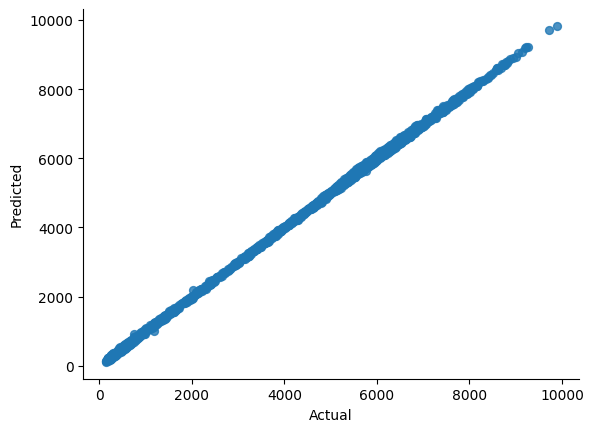

In [ ]:
# @title Actual vs Predicted

from matplotlib import pyplot as plt
results_lr.plot(kind='scatter', x='Actual', y='Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

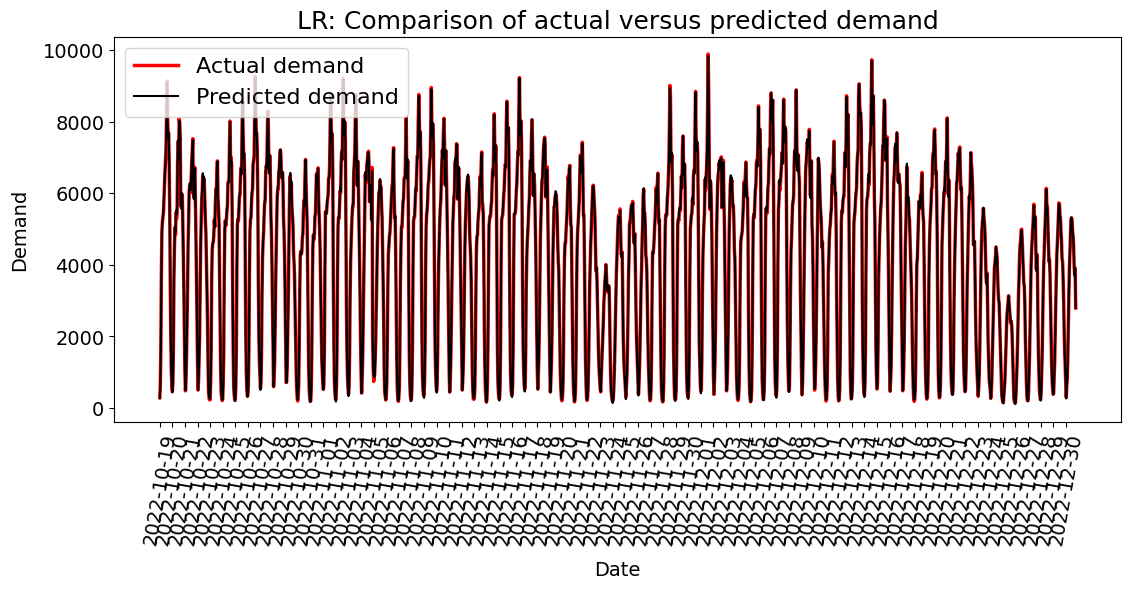

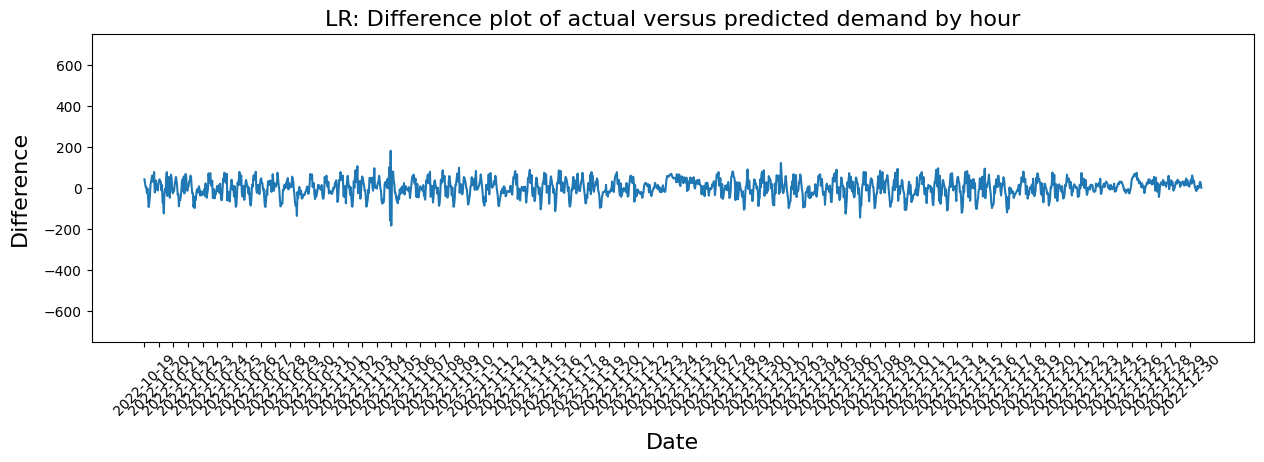

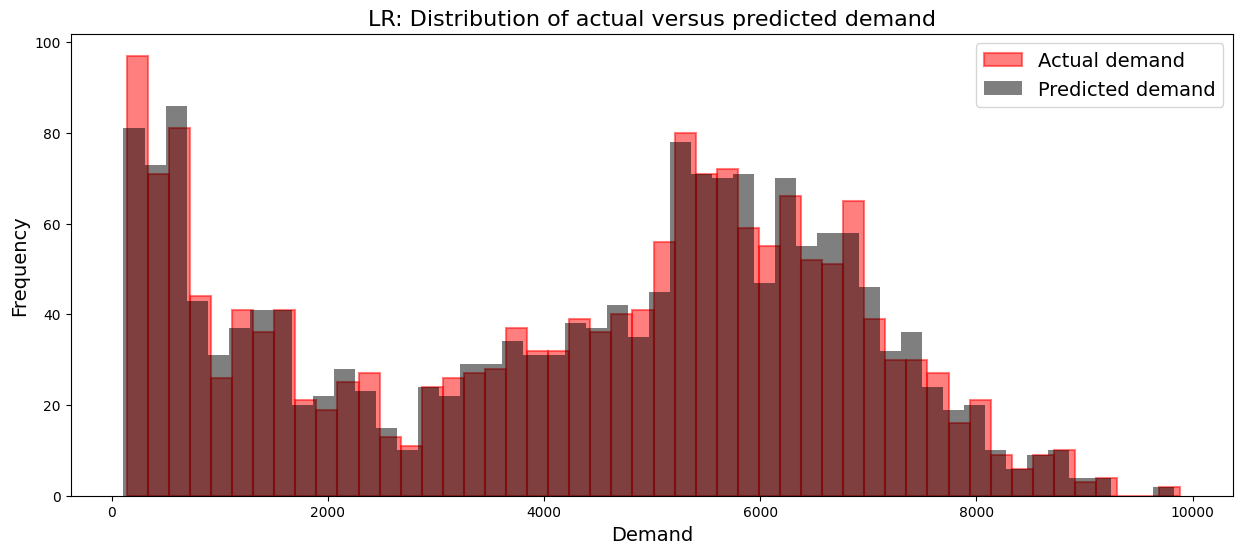

In [ ]:
# Time series plot of the actual versus predicted values for the test set
plt.figure(figsize=(13,5))
plt.plot(results_lr.index, results_lr['Actual'], label='Actual demand', color = 'red', linewidth = 2.5)
plt.plot(results_lr.index, results_lr['Predicted'], label='Predicted demand', color = 'black')
plt.xlabel('Date', fontsize = 14, labelpad = 10)
plt.xticks(results_lr.index[::24], results_lr.index.date[::24], rotation= 80, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Demand', fontsize = 14, labelpad = 10)
plt.title('LR: Comparison of actual versus predicted demand', fontsize = 18)
plt.legend(fontsize = 16)
plt.savefig('LR_actual_predicted.png', bbox_inches = 'tight')
plt.show()

# Difference plot of actual and predicted values for the test set
plt.figure(figsize=(15,4))
plt.plot(results_lr.index, results_lr['Difference'])
plt.xlabel('Date', fontsize = 16, labelpad = 10)
plt.xticks(results_lr.index[::24], results_lr.index.date[::24], rotation=45)
plt.ylim([-750, 750])  # Set y-axis limits
plt.ylabel('Difference', fontsize = 16, labelpad = 10)
plt.title('LR: Difference plot of actual versus predicted demand by hour', fontsize = 16)
plt.show()

# Distribution plot of actual and predicted values for the test set
plt.figure(figsize=(15,6))
plt.hist(results_lr['Actual'], bins=50, alpha=0.5, label='Actual demand', color = 'red', edgecolor='red', linewidth=1.5)
plt.hist(results_lr['Predicted'], bins=50, alpha=0.5, label='Predicted demand', color = 'black')
plt.xlabel('Demand', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('LR: Distribution of actual versus predicted demand', fontsize = 16)
plt.legend(fontsize = 14)
plt.savefig('LR_distribution_actual_predicted.png', bbox_inches = 'tight')
plt.show()

Random forest

In [ ]:
# Specification of categorical features
categorical_features = ['PU_hour']

In [ ]:
# Initialize an instance of the One-Hot-Encoder to pre-process the categorical features
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)

In [ ]:
# Create copies of the train and test data
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [ ]:
# Create a pipeline for random forest regression
# Column Transformer is used to one-hot-encode 'PU_hour'
rf_pipeline = make_pipeline(
    # The ColumnTransformer component allows for different transformations to be applied to different subsets of the input data
    ColumnTransformer(
        # Tuple specifying the name of the name of the transformation, and the transformer object to be applied on the categorical features
        transformers=[
        ("categorical", one_hot_encoder, categorical_features),
        ],
        # The remaining columns are not further transformed
        remainder= "passthrough",
    ),
    # Initialize Random Forest Regression
    RandomForestRegressor(n_jobs = -1)
)

In [ ]:
# Define hyperparameter search space
param_distributions = {
    "randomforestregressor__n_estimators":  [int (x) for x in np.linspace(start = 100, stop = 1000, num= 10)] , # Determine the number of trees (list of integer values ranging from 100 to 1000, with 10 evenly spaced values)
    "randomforestregressor__max_depth": [3,4,5,10,30,50,80,100], # Determine the maximum depth of each tree from the list of pre-defined values
    "randomforestregressor__min_samples_split": [2,4,6,8,10], # Determine the number of samples required to split an internal node from a list of pre-defined values
    "randomforestregressor__min_samples_leaf": [1,2,4,5,8,10], # Determine the number of samples required to be at a leaf node from a list of pre-defined values
    "randomforestregressor__max_features": ["auto", "sqrt", "log2"], # Determine the number of features to consider when looking for the best split
}

# Number of parameter settings that are sampled
n_iter = 100

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    rf_pipeline, param_distributions, n_iter=n_iter, verbose=1, n_jobs=-1, cv = 2
)
random_search.fit(X_train_rf, y_train)

# Print the best hyparameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Save the best model
best_random_forest = random_search.best_estimator_
dump(best_random_forest, 'best_random_forest.joblib')

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Best Parameters:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100}
Best Score:  0.9942671467963344


['best_random_forest.joblib']

Performance evaluation of the tuned random forest model

In [ ]:
# Load the saved model
best_random_forest = load('best_random_forest.joblib')

In [ ]:
# Create predictions for the train set
y_pred_train_rf = best_random_forest.predict(X_train_rf)

# Calculate RMSE and MAE for the train set
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)

# Print the RMSE and MAE for the train set
print("Train set:")
print(f"RMSE: {rmse_train_rf:.2f}")
print(f"MAE: {mae_train_rf:.2f}")

# Create predictions for the test set
y_pred_test_rf = best_random_forest.predict(X_test_rf)

# Calculate metrics for the test set
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

# Print the RMSE and MAE for the test set
print("Test set:")
print(f"RMSE: {rmse_test_rf:.2f}")
print(f"MAE: {mae_test_rf:.2f}")

Train set:
RMSE: 40.77
MAE: 25.10
Test set:
RMSE: 156.91
MAE: 99.53


Visualizations of performance results

In [ ]:
# A dataframe of the actual versus predicted values for the test set is created:

# Round predicted values to integers
y_pred_test_rf_rounded = y_pred_test_rf.round().astype(int)

# Create a dataframe of the actual and rounded predicted values
results_rf = pd.DataFrame({'Actual': y_test_array, 'Predicted': y_pred_test_rf_rounded}, index=X_test_lr_datetime.index)

# Calculate the difference between actual and predicted values and store the difference in a new column
results_rf['Difference'] = results_rf['Actual'] - results_rf['Predicted']

# Print the dataframe
results_rf

,Actual,Predicted,Difference
datetime,,,
2022-10-19 04:00:00,304,317,-13
2022-10-19 05:00:00,587,604,-17
2022-10-19 06:00:00,1608,1616,-8
2022-10-19 07:00:00,3648,3663,-15
2022-10-19 08:00:00,4909,4919,-10
...,...,...,...
2022-12-30 19:00:00,4549,4563,-14
2022-12-30 20:00:00,3981,4054,-73
2022-12-30 21:00:00,3729,3690,39


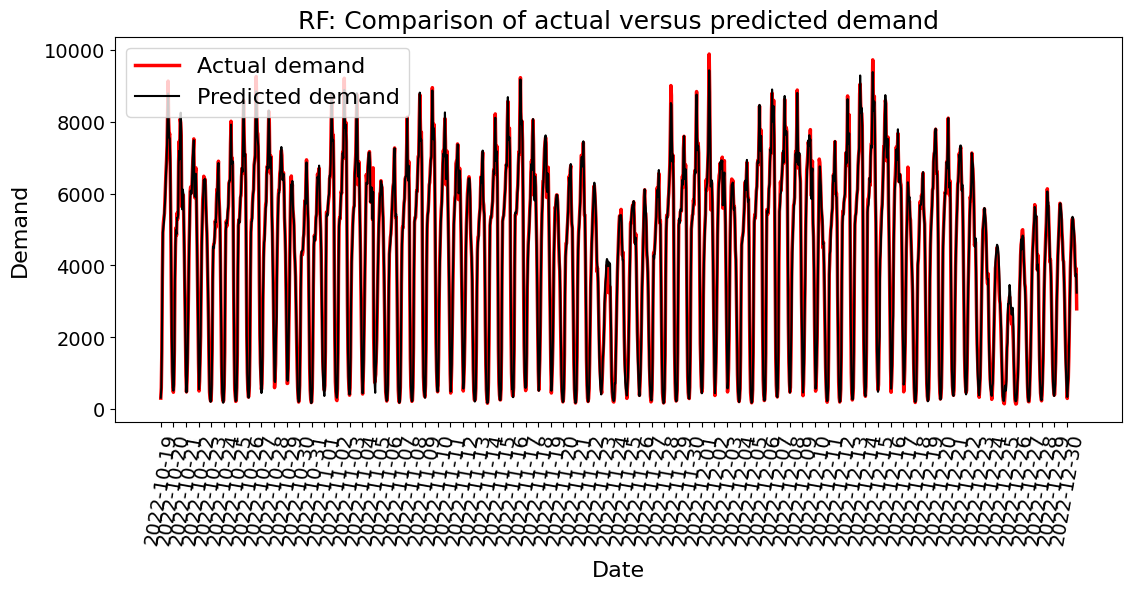

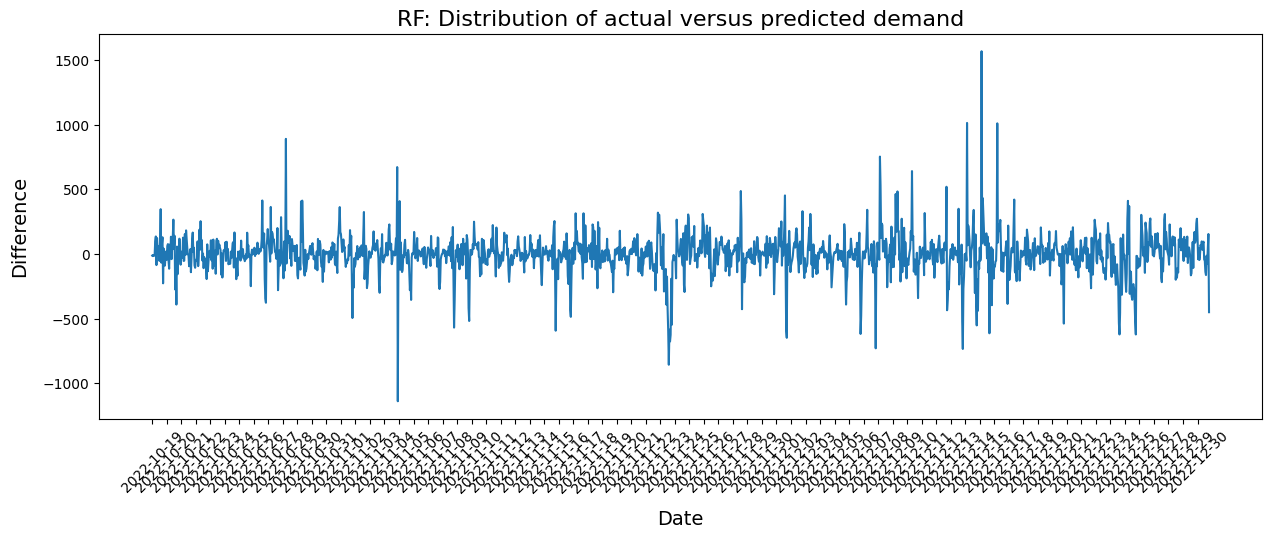

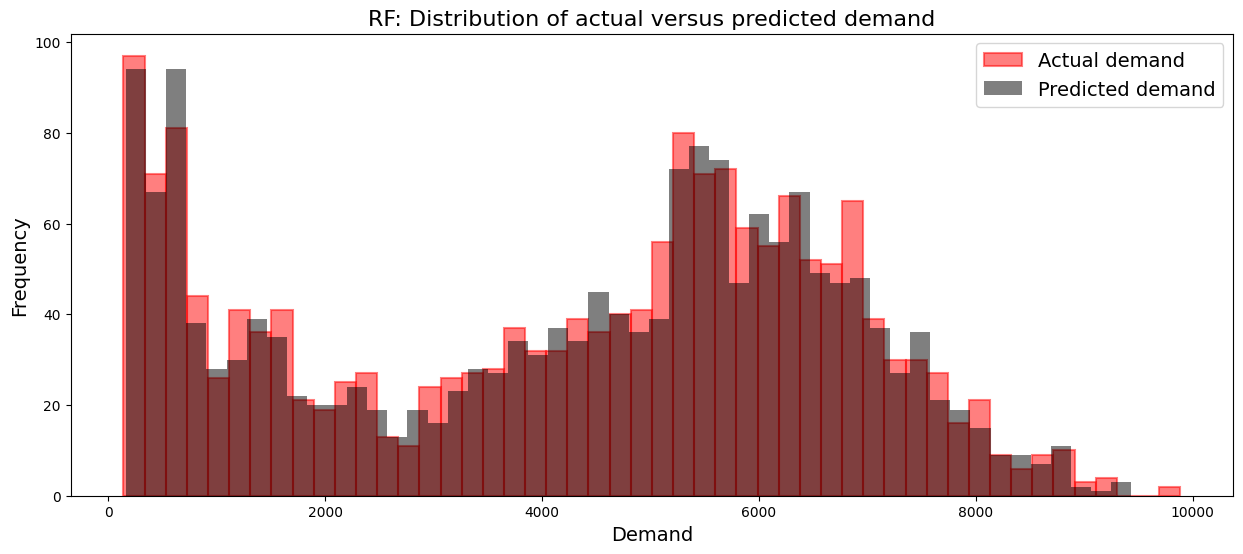

In [ ]:
# Time series plot of actual versus predicted results

plt.figure(figsize=(13,5))
plt.plot(results_rf.index, results_rf['Actual'], label='Actual demand', color = 'red', linewidth = 2.5)
plt.plot(results_rf.index, results_rf['Predicted'], label='Predicted demand', color = 'black')
plt.xlabel('Date', fontsize = 16, labelpad = 10)
plt.xticks(results_rf.index[::24], results_rf.index.date[::24], rotation=80, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Demand', fontsize = 16, labelpad = 10)
plt.title('RF: Comparison of actual versus predicted demand', fontsize = 18)
plt.legend(fontsize = 16)
plt.savefig('RF_actual_predicted.png', bbox_inches = 'tight')
plt.show()

# Difference plot of actual versus predicted values

plt.figure(figsize=(15,5))
plt.plot(results_rf.index, results_rf['Difference'])
plt.xlabel('Date', fontsize = 14, labelpad = 10)
plt.xticks(results_rf.index[::24], results_rf.index.date[::24], rotation=45)
plt.ylabel('Difference', fontsize = 14, labelpad = 10)
plt.title('RF: Distribution of actual versus predicted demand', fontsize = 16)
plt.show()

# Distribution plot of actual and predicted values

plt.figure(figsize=(15,6))
plt.hist(results_rf['Actual'], bins=50, alpha=0.5, label='Actual demand', color = 'red', edgecolor = 'red', linewidth = 1.5)
plt.hist(results_rf['Predicted'], bins=50, alpha=0.5, label='Predicted demand', color = 'black')
plt.xlabel('Demand', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('RF: Distribution of actual versus predicted demand', fontsize = 16)
plt.legend(fontsize = 14)
plt.savefig('RF_distribution_actual_predicted.png', bbox_inches = 'tight')
plt.show()

Comparison of the temporal forecasting models

In [ ]:
results_lr.rename(columns = {'Predicted': 'Predicted_LR',
                            'Difference': 'Difference_LR'}, inplace = True)
results_rf.rename(columns = {'Predicted' : 'Predicted_RF',
                            'Difference' : 'Difference_RF'}, inplace = True)

In [ ]:
# Merge the dataframes results_lr, results_rf, and results_lstm based on their datetime indices
results_all_models = pd.merge(results_lr,results_rf,left_index = True,right_index=True)

# Drop unnecessary columns and rename the column that displays the actual values

# Print the merged dataframe
print(results_all_models)

                     Actual_x  Predicted_LR  Difference_LR  Actual_y  \
datetime                                                               
2022-10-19 04:00:00       304           263             41       304   
2022-10-19 05:00:00       587           565             22       587   
2022-10-19 06:00:00      1608          1605              3      1608   
2022-10-19 07:00:00      3648          3646              2      3648   
2022-10-19 08:00:00      4909          4934            -25      4909   
...                       ...           ...            ...       ...   
2022-12-30 19:00:00      4549          4549              0      4549   
2022-12-30 20:00:00      3981          3967             14      3981   
2022-12-30 21:00:00      3729          3700             29      3729   
2022-12-30 22:00:00      3913          3891             22      3913   
2022-12-30 23:00:00      2792          2792              0      2792   

                     Predicted_RF  Difference_RF  
datetime    

In [ ]:
results_all_models.drop(columns=['Actual_y'], inplace=True)

# Rename 'Actual_x' to 'Actual'
results_all_models.rename(columns={'Actual_x': 'Actual'}, inplace=True)

# Print the merged dataframe
print(results_all_models)

                     Actual  Predicted_LR  Difference_LR  Predicted_RF  \
datetime                                                                 
2022-10-19 04:00:00     304           263             41           317   
2022-10-19 05:00:00     587           565             22           604   
2022-10-19 06:00:00    1608          1605              3          1616   
2022-10-19 07:00:00    3648          3646              2          3663   
2022-10-19 08:00:00    4909          4934            -25          4919   
...                     ...           ...            ...           ...   
2022-12-30 19:00:00    4549          4549              0          4563   
2022-12-30 20:00:00    3981          3967             14          4054   
2022-12-30 21:00:00    3729          3700             29          3690   
2022-12-30 22:00:00    3913          3891             22          3759   
2022-12-30 23:00:00    2792          2792              0          3242   

                     Difference_RF  


In [ ]:
# Set the end datetime as the last predicted datetime in the test set
end_datetime = results_all_models.index[-2]

# Set the start datetime as 24 hours before the end datetime
start_datetime = end_datetime - pd.Timedelta(hours=24)

# Filter the results for the desired time span
results_24h_all_models = results_all_models[(results_all_models.index >= start_datetime) & (results_all_models.index <= end_datetime)]
results_24h_all_models

,Actual,Predicted_LR,Difference_LR,Predicted_RF,Difference_RF
datetime,,,,,
2022-12-29 22:00:00,4106,4061,45,3996,110
2022-12-29 23:00:00,3656,3644,12,3486,170
2022-12-30 00:00:00,3030,2993,37,2943,87
2022-12-30 01:00:00,2182,2168,14,2071,111
2022-12-30 02:00:00,1580,1567,13,1343,237
2022-12-30 03:00:00,1141,1136,5,869,272
2022-12-30 04:00:00,667,649,18,534,133
2022-12-30 05:00:00,296,266,30,337,-41
2022-12-30 06:00:00,636,595,41,591,45


Visualization of the results of the temporal forecasting models

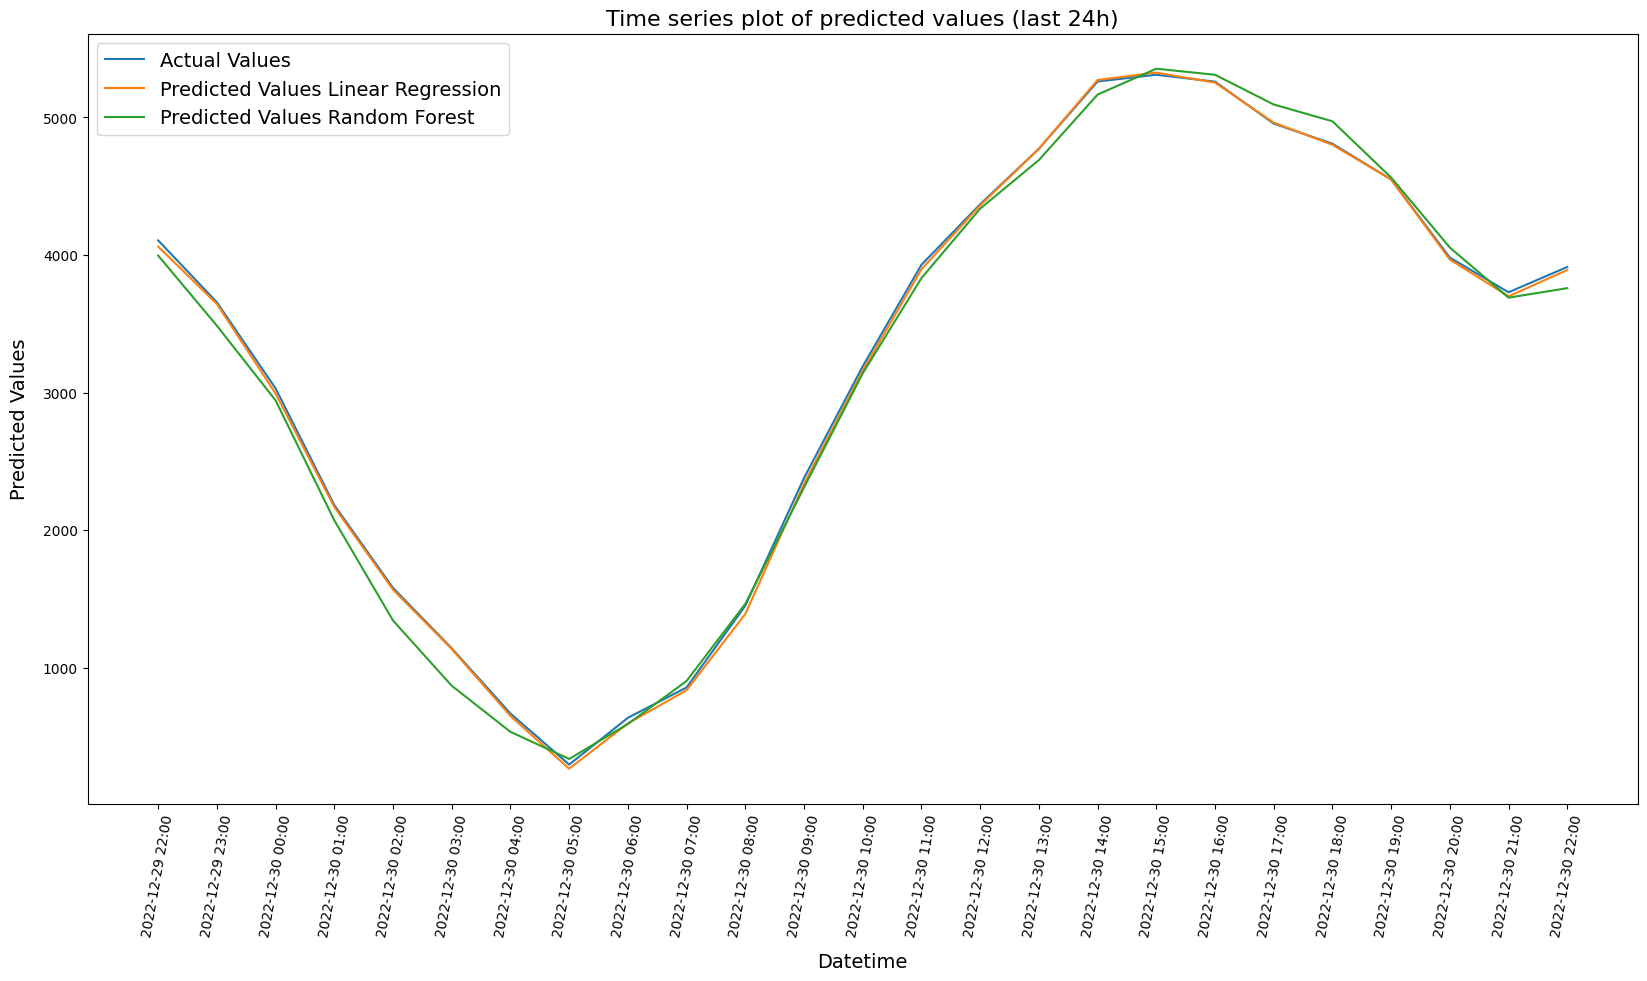

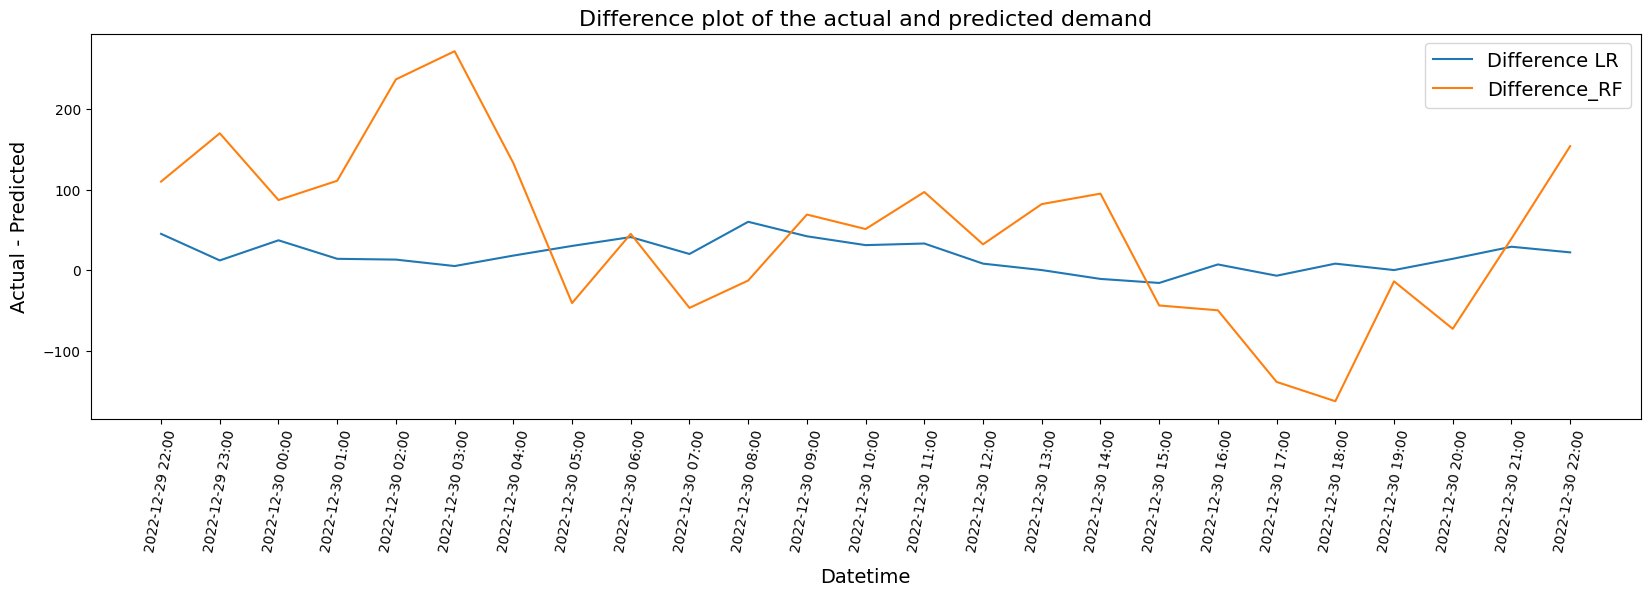

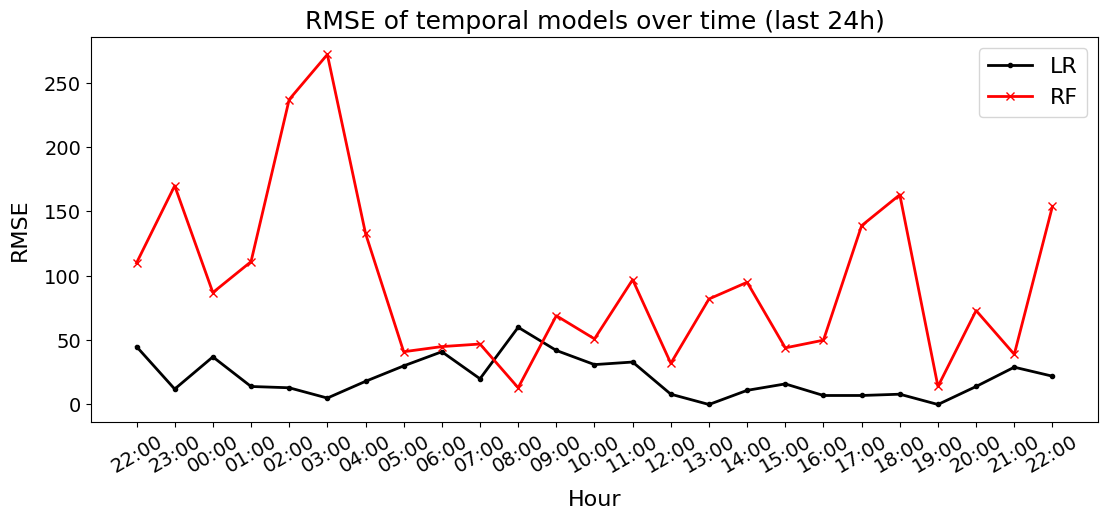

In [ ]:
# Time series plot of the actual versus predicted values on the last 24 hours of the test set
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(results_24h_all_models.index, results_24h_all_models['Actual'], label='Actual Values')
ax.plot(results_24h_all_models.index, results_24h_all_models['Predicted_LR'], label='Predicted Values Linear Regression')
ax.plot(results_24h_all_models.index, results_24h_all_models['Predicted_RF'], label='Predicted Values Random Forest')

ax.set_xlabel('Datetime', fontsize = 14, labelpad = 10)
ax.set_ylabel('Predicted Values', fontsize = 14, labelpad = 10)
ax.set_title('Time series plot of predicted values (last 24h)', fontsize = 16)
plt.xticks(rotation=80)
ax.set_xticks(results_24h_all_models.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.legend(fontsize = 14)
plt.show()

# Difference plot of actual versus predicted values on the last 24 hours of the test set
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(results_24h_all_models.index, results_24h_all_models['Difference_LR'], label = 'Difference LR')
ax.plot(results_24h_all_models.index, results_24h_all_models['Difference_RF'], label = 'Difference_RF')

ax.set_xlabel('Datetime', fontsize = 14, labelpad = 10)
plt.xticks(rotation= 80)
ax.set_xticks(results_24h_all_models.index)
ax.set_ylabel('Actual - Predicted', fontsize = 14, labelpad = 10)
ax.set_title('Difference plot of the actual and predicted demand', fontsize = 16)
ax.legend(fontsize = 14)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.show()

# Comparison plot of the RMSE of the temporal models on the last 24 hours of the test set
# Calculate the squared error for each datetime
results_24h_all_models['Squared_Error_LR'] = (results_24h_all_models['Actual'] - results_24h_all_models['Predicted_LR'])**2
results_24h_all_models['Squared_Error_RF'] = (results_24h_all_models['Actual'] - results_24h_all_models['Predicted_RF'])**2

# Take the square root of the mean squared error to get the RMSE
results_24h_all_models['RMSE_LR'] = np.sqrt(results_24h_all_models['Squared_Error_LR'])
results_24h_all_models['RMSE_RF'] = np.sqrt(results_24h_all_models['Squared_Error_RF'])


# Plot the RMSE over time
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(results_24h_all_models.index, results_24h_all_models['RMSE_LR'], label = 'LR',  marker='.', color = 'black', linewidth = 2)
ax.plot(results_24h_all_models.index, results_24h_all_models['RMSE_RF'], label = 'RF', marker = 'x', color = 'red', linewidth = 2)

ax.set_xlabel('Hour', fontsize = 16, labelpad = 10)
ax.set_ylabel('RMSE', fontsize = 16, labelpad = 10)
ax.set_title('RMSE of temporal models over time (last 24h)', fontsize = 18)
plt.xticks(rotation = 30, fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xticks(results_24h_all_models.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(fontsize = 16)
plt.savefig('RMSE_temporal.png', bbox_inches = 'tight')
plt.show()